# Using Siphon with NCI THREDDS Data Server

Siphon is a collection of Python utilities for downloading data from Unidata data technologies. More information on installing and using Unidata's Siphon can be found: 
https://github.com/Unidata/siphon

**The following will go through how to:** <br \>
- Use Siphon to find and query MODIS data hosted on NCI THREDDS Data Server

<br>
<br/>


### Import python packages

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt 
from siphon import catalog, ncss
import datetime
%matplotlib inline

/Users/kdruken/anaconda/envs/mypy2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Start by defining the parent catalog URL from NCI's THREDDS Data Server

In [2]:
url = 'http://dapds00.nci.org.au/thredds/catalog/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/catalog.xml'

### Use Siphon to explore the available datasets and data services end points

#### In this Notebook, we'll be demonstrating the Netcdf Subset Service (NCSS)

In [3]:
tds = catalog.TDSCatalog(url)
datasets = list(tds.datasets)
endpts = tds.datasets.values()

##### The possible data services end points through NCI's THREDDS includes: OPeNDAP, Netcdf Subset Service (NCSS), HTTP download, Web Map Service (WMS), Web Coverage Service (WCS), NetCDF Markup Language (NcML), and a few metadata services (ISO, UDDC). 

In [4]:
for key, value in endpts[0].access_urls.items():
    print key, value

UDDC http://dapds00.nci.org.au/thredds/uddc/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
WCS http://dapds00.nci.org.au/thredds/wcs/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
HTTPServer http://dapds00.nci.org.au/thredds/fileServer/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
WMS http://dapds00.nci.org.au/thredds/wms/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
NCML http://dapds00.nci.org.au/thredds/ncml/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
NetcdfSubset http://dapds00.nci.org.au/thredds/ncss/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
ISO http://dapds00.nci.org.au/thredds/iso/u39/public/data/modis/fractionalcover-clw/v2.2/netcdf/FractCover.V2_2.2012.121.aust.005.nc.gz
OPENDAP http://dapds

### We can create a small function that uses Siphon's Netcdf Subset Service (NCSS) to extract a spatial request (defined by a lat/lon box)

In [5]:
def get_data(dataset, bbox):    
    nc = ncss.NCSS(dataset.access_urls['NetcdfSubset'])
    query = nc.query()
    query.lonlat_box(north=bbox[3],south=bbox[2],east=bbox[1],west=bbox[0])
    query.variables('bs')
    
    data = nc.get_data(query)
    
    lon = data['longitude'][:]
    lat = data['latitude'][:]
    bs = data['bs'][0,:,:]
    t = data['time'][:]
    
    time_base = datetime.date(year=1800, month=1, day=1)
    time = time_base + datetime.timedelta(t[0])
    
    return lon, lat, bs, time

### Query a single file and view result

In [6]:
bbox = (135, 140, -31, -27)
lon, lat, bs, t = get_data(endpts[0], bbox)

Date:  2000-02-18


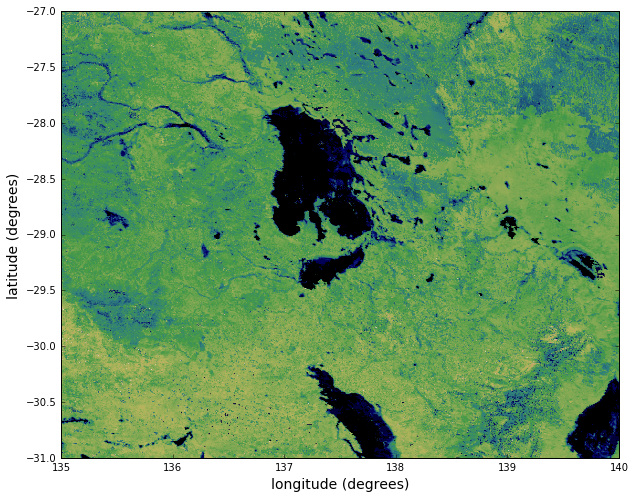

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(bs, extent=bbox, cmap='gist_earth', origin='upper')

plt.xlabel('longitude (degrees)', fontsize=14)
plt.ylabel('latitude (degrees)', fontsize=14)
print "Date: ", t

### Loop and query over the collection

In [8]:
bbox = (135, 140, -31, -27)
plt.figure(figsize=(10,10))

for endpt in endpts[:15]:
    try:
        lon, lat, bs, t = get_data(endpt, bbox)

        plt.imshow(bs, extent=bbox, cmap='gist_earth', origin='upper')
        plt.clim(vmin=-2, vmax=100)

        plt.tick_params(labelsize=14)
        plt.xlabel('longitude (degrees)', fontsize=14)
        plt.ylabel('latitude (degrees)', fontsize=14)

        plt.title("Date: "+str(t), fontsize=16, weight='bold')
        plt.savefig("./images/"+endpt.name+".png")
        plt.cla()
    except:
        pass

plt.close()

### Can make an animation of the temporal evolution (this example is by converting the series of *.png files above into a GIF)
<img src="./images/animated.gif">

### Can also use Siphon to extract a single point

In [14]:
def get_point(dataset, lat, lon):
    nc = ncss.NCSS(dataset.access_urls['NetcdfSubset'])
    query = nc.query()
    query.lonlat_point(lon, lat)
    query.variables('bs')
    
    data = nc.get_data(query)
    bs = data['bs'][0]
    date = data['date'][0]
    
    print query
    
    return bs, date

In [15]:
bs, date = get_point(endpts[4], -27.75, 137)
print bs, date

var=bs&latitude=-27.75&longitude=137
54.0 2004-01-01 00:00:00+00:00


In [13]:
print query

var=bs&latitude=137&longitude=-27.75


### Time series example

In [14]:
data = []
for endpt in endpts[::20]:
    bs, date = get_point(endpt, -27.75, 137)
    data.append([date, bs])

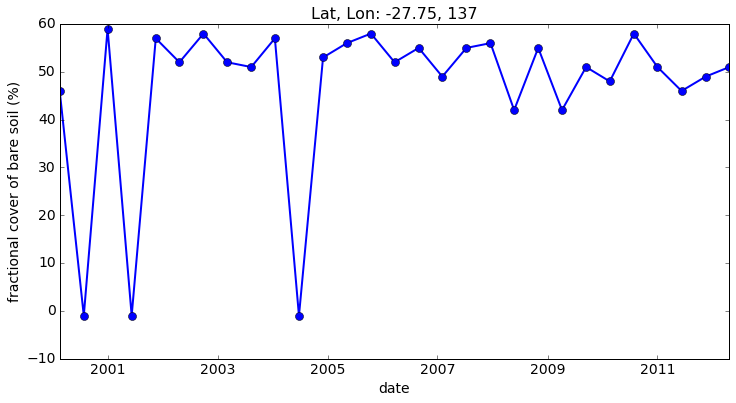

In [23]:
import numpy as np

BS = np.array(data)[:,1]
Date = np.array(data)[:,0]

plt.figure(figsize=(12,6))
plt.plot(Date, BS, '-o', linewidth=2, markersize=8)

plt.tick_params(labelsize=14)
plt.xlabel('date', fontsize=14)
plt.ylabel('fractional cover of bare soil (%)', fontsize=14)
plt.title('Lat, Lon: -27.75, 137', fontsize=16)